<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Signal%20Processing%20-%20Synthetic%20Dataset%20(LSTM%20Model)/signal_processing_synthetic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libararies

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Generate Synthetic Signal

In [3]:
def generate_signal(n_samples=10000, freq=1, sample_rate=100, noise_level=0.1):
    # Time Vector
    t = np.linspace(0, n_samples/sample_rate, n_samples)
    # Sinusoidal signal
    signal = np.sin(2 * np.pi * freq * t)
    # Guassian noise
    noise = np.random.normal(0, noise_level, n_samples)
    signal_noisy = signal + noise
    df = pd.DataFrame({"time": t, "signal": signal_noisy})
    df.set_index('time', inplace=True)
    return df


df = generate_signal()
print("\n\nDataset info:")
df.info()



Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0.0 to 100.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   signal  10000 non-null  float64
dtypes: float64(1)
memory usage: 156.2 KB


In [4]:
df.head()

,signal
time,
0.000000,0.017748
0.010001,0.027406
0.020002,0.067805
0.030003,0.224171
0.040004,0.222069


# Preprocess Data

In [8]:
def preprocess_data(df, time_steps=50):
    scaler = MinMaxScaler()
    signal_scaled = scaler.fit_transform(df[['signal']])
    df_scaled = pd.DataFrame(signal_scaled, index=df.index, columns=["signal"])

    # Create seq
    X, y = [], []
    for i in range(time_steps, len(df_scaled)):
        X.append(df_scaled.iloc[i - time_steps : i].values)
        y.append(df_scaled.iloc[i].values[0])
    X, y = np.array(X), np.array(y)

    # Split train/test
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler, df_scaled

# Apply function
time_steps = 50
X_train, X_test, y_train, y_test, scaler, df_scaled = preprocess_data(df, time_steps)
print(f"X_train shape: {X_train.shape}\t |\t y_train shape: {y_train.shape}")
print(f"X_testh shape: {X_test.shape}\t |\t y_test shape: {y_test.shape}")

X_train shape: (7960, 50, 1)	 |	 y_train shape: (7960,)
X_testh shape: (1990, 50, 1)	 |	 y_test shape: (1990,)


# Build LSTM Model

In [9]:
def build_lstm_model(time_steps, n_features=1):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='relu',
                   input_shape=(time_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Apply function
model = build_lstm_model(time_steps)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0699 - val_loss: 0.0044
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0087 - val_loss: 0.0033
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0074 - val_loss: 0.0029
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 9/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 10/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 11/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 12/50
199/199 ━━━━━━━━━━━━━━━

In [22]:
def evaluate_model(model, X_test, y_test, scaler):
    """Evaluate model performance."""
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)

    print(f"\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return y_pred_unscaled, y_test_unscaled

y_pred_unscaled, y_test_unscaled = evaluate_model(model, X_test, y_test, scaler)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Evaluation Metrics:
MSE: 0.0106
RMSE: 0.1031


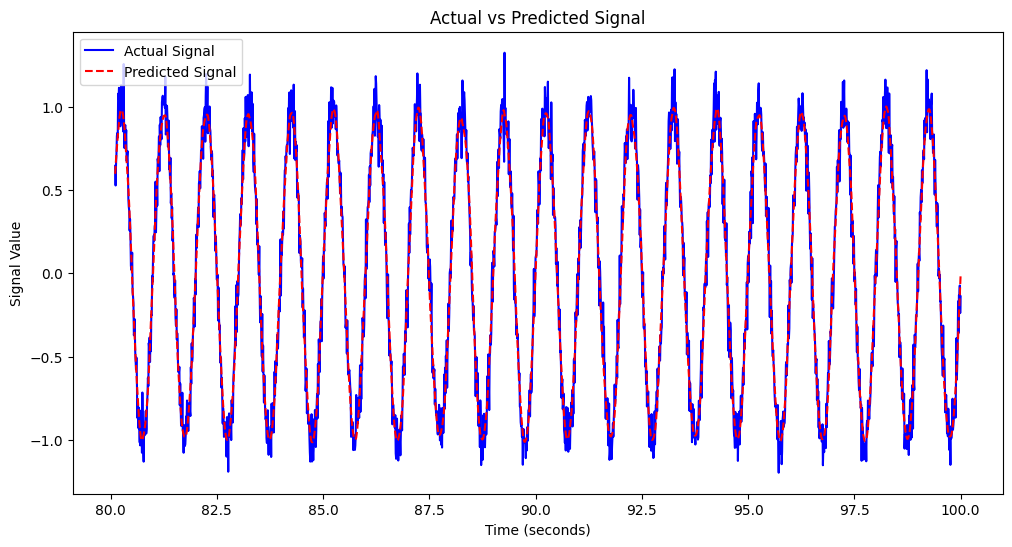

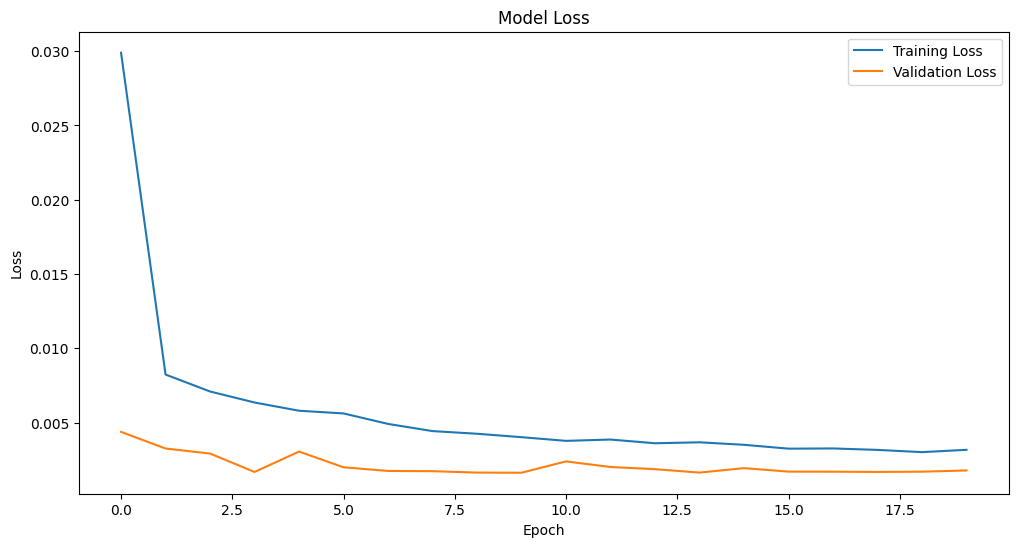

In [23]:
def plot_results(df_scaled, y_test_unscaled, y_pred_unscaled, train_size, time_steps):
    """Plot original and predicted signals."""
    test_indices = df_scaled.index[train_size + time_steps:train_size + time_steps + len(y_test_unscaled)]

    plt.figure(figsize=(12, 6))
    plt.plot(test_indices, y_test_unscaled, label='Actual Signal', color='blue')
    plt.plot(test_indices, y_pred_unscaled, label='Predicted Signal', color='red', linestyle='--')
    plt.title('Actual vs Predicted Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_results(df_scaled, y_test_unscaled, y_pred_unscaled, train_size=len(X_train), time_steps=time_steps)